In [28]:
import os
import sys
from pathlib import Path
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
from skimage.measure import regionprops_table
from skimage import exposure, measure
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

In [4]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [8]:
# Define image and masks folder
info_csv = data_meta / "info_combined.csv"

df = pd.read_csv(info_csv)

In [9]:
df = df[df.After_bleach==True]

# Get nuclei, cyto, cell level features

In [14]:
def get_location(df, location):
    imgs_path = []
    markers = []
    df = df[df.Location == location]
    for row in df.itertuples():
        if row.Marker == 'Hoeschst' and row.Cycle != 'Cycle1':
            continue
        imgs_path.append(row.Path)
        markers.append(row.Marker)
    return imgs_path, markers


def get_region_props(img, cell, nuclei, cyto, marker, location, prop):
    """
    Get regionprops from masked region
    """
    cell_props = regionprops_table(cell, img, properties=prop)
    nuclei_props = regionprops_table(nuclei, img, properties=prop)
    cyto_props = regionprops_table(cyto, img, properties=prop)

    props = [cell_props, nuclei_props, cyto_props]
    prefix = ["Cell_", "Nuclei_", "Cyto_"]
    df_marker = pd.concat(
        [pd.DataFrame(prop).add_prefix(prefix[idx]) for idx, prop in enumerate(props)],
        axis=1,
    )
    df_marker["Marker"] = marker
    df_marker["Location"] = location
    df_marker["Id"] = regionprops_table(cell, properties=["label"])["label"]

    return df_marker


def measure_prop(df, masks, show=False, save=False):
    appended_data_intensity = []
    appended_data_morphology = []

    # Get each segmented cell region with corresponding nuclei and cell
    for idx, location in enumerate(masks.keys()):
        # Get cell masks
        mask_cyto = masks[location]["cyto"]
        mask_nuclei = masks[location]["nuclei"]
        cell, nuclei, cyto = my_utils.qc_nuclei(mask_cyto, mask_nuclei)
        x,y = cell.shape
        # Get images
        imgs, markers = get_location(df, int(location))
        for idx, img_path in enumerate(imgs):
            img = skimage.io.imread(img_path)
            p2, p98 = np.percentile(img, (0, 99.9))
            img = exposure.rescale_intensity(img, in_range=(p2, p98))
            img = img[:x, :y]
#             print(img.shape, cell.shape, nuclei.shape, cyto.shape)
            df_marker = get_region_props(
                img, cell, nuclei, cyto, markers[idx], location, ["mean_intensity"]
            )
            appended_data_intensity.append(df_marker)

            # Get morphology only one time because morphology accross cell are the same
            if idx == 0:
                df_marker = get_region_props(
                    img, cell, nuclei, cyto, markers[idx], location, ["area"]
                )
                appended_data_morphology.append(df_marker)

                if show:
                    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                    ax[0].imshow(cell)
                    ax[1].imshow(nuclei)
                    ax[2].imshow(cyto)
                    plt.show()

    df_prop_intensity = pd.concat(appended_data_intensity, ignore_index=True)
    df_prop_intensity = df_prop_intensity.sort_values(
        by=["Location", "Id"]
    ).reset_index(drop=True)

    df_prop_morph = pd.concat(appended_data_morphology, ignore_index=True)
    df_prop_morph = df_prop_morph.sort_values(by=["Location", "Id"]).reset_index(
        drop=True
    )

    if save:
        df_prop_intensity.to_csv(data_meta / "measurements_intensity.csv", index=False)
        df_prop_morph.to_csv(data_meta / "measurements_morphology.csv", index=False)

    return df_prop_intensity, df_prop_morph

In [12]:
masks = my_utils.get_masks(data_mask)

In [15]:
df_prop_i, df_prop_m = measure_prop(df, masks, save=False, show=False)

In [ ]:
df_prop_i

# Correlation

In [16]:
df_intensity = df_prop_i
df_morph = df_prop_m

In [17]:
# Calculate total intensity from mena intensity and area size
for row in df_intensity.itertuples():
    cond = row.Location
    i = row.Id
    total_nuclei_intensity = (
        row.Nuclei_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)][
            "Nuclei_area"
        ].item()
    )
    total_cyto_intensity = (
        row.Cyto_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)]["Cyto_area"].item()
    )
    df_intensity.loc[row.Index, "Nuclei_total_intensity"] = total_nuclei_intensity
    df_intensity.loc[row.Index, "Cyto_total_intensity"] = total_cyto_intensity

In [18]:
df_intensity.replace('Hoeschst', 'DAPI', inplace=True)
df_intensity

,Cell_mean_intensity,Nuclei_mean_intensity,Cyto_mean_intensity,Marker,Location,Id,Nuclei_total_intensity,Cyto_total_intensity
0,11706.123220,20553.689770,6839.256589,DAPI,1,1,92224406.0,55787816.0
1,11511.650902,14822.108759,9690.635283,p-EGFR,1,1,66506802.0,79046512.0
2,10409.736476,18331.031424,6052.393037,Concanavalin A,1,1,82251338.0,49369370.0
3,16108.496678,16334.691108,15984.071718,PCNA,1,1,73293759.0,130382073.0
4,11706.823315,10546.372632,12345.163663,Phalloidin,1,1,47321574.0,100699500.0
...,...,...,...,...,...,...,...,...
89877,19170.113495,18740.682984,19186.599016,B-tubin,9,53,8039753.0,214410244.0
89878,9411.035505,7472.874126,9485.440089,Cyclin D1,9,53,3205863.0,105999793.0
89879,6854.219235,5023.909091,6924.483490,H3k27me3-488,9,53,2155257.0,77381103.0
89880,22372.421062,21107.454545,22420.982192,H3k4me3-647,9,53,9055098.0,250554476.0


In [46]:
df_intensity = df_intensity[~df_intensity.Marker.isin(['PCNA', 'DAPI', 'WGA', 'B-tubin', 'Concanavalin A', 'Phalloidin', 'B-actin'])]
# df_intensity = df_intensity[~df_intensity.Marker.isin(['PCNA', 'B-tubin', 'B-actin'])]
# df_intensity = df_intensity[~df_intensity.Marker.isin(['DAPI', 'WGA', 'Concanavalin A', 'Phalloidin', 'PCNA'])]

In [47]:
df_cell = df_intensity[['Marker', 'Location', 'Id']]
# df_cell['Intensity'] = df_intensity.iloc[:,-2] + df_intensity.iloc[:,-1]
df_cell['Intensity'] = df_intensity.iloc[:,0]
df_cell = df_cell.pivot(index=['Location','Id'], columns='Marker', values="Intensity")

C:\Users\thu71\AppData\Local\Temp/ipykernel_34260/3772680997.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell['Intensity'] = df_intensity.iloc[:,0]


In [48]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(np.log(df_cell+1))
# x_scaled = scaler.fit_transform(x_scaled.T).T
# df_cell = pd.DataFrame(
#     x_scaled, index=df_cell.index, columns=df_cell.columns
# )

In [61]:
def get_data_per_condition_mean(df, scaler, condition=None):
    # Read information
    df_list = []
    df_cell_intensity = df.iloc[:,[1, 3, 4, 5]]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, [0,-1]]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
        
    df_subset.rename(columns={"Nuclei_mean_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Nuclei"
    df_list.append(df_subset)

    df_cell_intensity = df.iloc[:, 2:6]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, [0,-1]]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    df_subset.rename(columns={"Cyto_mean_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Cyto"
    df_list.append(df_subset)

    df_subset = pd.concat(df_list)

    # Pivot the dataframe
    df_per_cell = (
        df_subset.set_index(["Id", "Marker", "Location"])
        .unstack()
        .unstack()
        .droplevel(0, axis=1)
    )

    # # Scale the data
    x_scaled = scaler.fit_transform(np.log(df_per_cell+1))
    x_scaled = scaler.fit_transform(x_scaled.T).T
    df_per_cell_scaled = pd.DataFrame(
        x_scaled, index=df_per_cell.index, columns=df_per_cell.columns
    )

    return df_per_cell

def get_data_per_condition(df, scaler, condition=None):
    # Read information
    df_list = []
    df_cell_intensity = df.iloc[:, 3:-1]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, -2:]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    
    df_subset.rename(columns={"Nuclei_total_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Nuclei"
    df_list.append(df_subset)

    df_cell_intensity = df.iloc[:, [3, 4, 5, 7]]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, -2:]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    df_subset.rename(columns={"Cyto_total_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Cyto"
    df_list.append(df_subset)

    df_subset = pd.concat(df_list)

    # Pivot the dataframe
    df_per_cell = (
        df_subset.set_index(["Id", "Marker", "Location"])
        .unstack()
        .unstack()
        .droplevel(0, axis=1)
    )

    # Scale the data
    x_scaled = scaler.fit_transform(np.log(df_per_cell+1))
    x_scaled = scaler.fit_transform(x_scaled.T).T
    df_per_cell_scaled = pd.DataFrame(
        x_scaled, index=df_per_cell.index, columns=df_per_cell.columns
    )

    return df_per_cell

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_per_cell_scaled = get_data_per_condition_mean(df_intensity, scaler)


C:\Users\thu71\AppData\Local\Temp/ipykernel_34260/2967649862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Marker"] = df.Marker
C:\Users\thu71\AppData\Local\Temp/ipykernel_34260/2967649862.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
C:\Users\thu71\.conda\envs\thomas-env\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

In [63]:
df_cell

Marker                AKT           APC         AXIN1     Cyclin D1  \
Location Id                                                           
1        1   13512.906280  12582.618871  10031.776890  10970.682616   
         2    4085.737522   6132.805929   2889.800830   3300.641027   
         3   14054.250304  15307.875492  15571.509699  16002.653819   
         4   11848.301154  15217.969738  15490.599741  15637.586690   
         5   10425.088349  13361.953097   8660.605434   9622.347608   
...                   ...           ...           ...           ...   
9        49  15033.796227  14718.385352  13922.193472  13777.984172   
         50  11895.968875  13183.409551  12883.960297  12674.531683   
         51   3718.646697   6167.271768   4536.098949   4173.141586   
         52   5437.054571   7861.540245   7178.409755   6920.777090   
         53   8779.766460  10542.061358  10270.029128   9411.035505   

Marker           Cyclin E          DKK1          DKK2          EGFR  \
Location Id                                                           
1        1   12256.710297  16692.452942  13435.351629  16707.666166   
         2    5137.901344  10024.742665   4884.755456   9337.611296   
         3   12054.766982  24343.081240  14474.227042  24004.378892   
         4    9298.446519  17927.464752  12134.096526  18041.526856   
         5    9684.312858  19092.272735   9609.700204  18215.155093   
...                   ...           ...           ...           ...   
9        49  14513.818855  19342.457260  15043.569333  19319.924793   
         50  11845.951094  17021.432755  11437.045290  16942.278380   
         51   3821.157818  16510.314073   3588.237176  15530.395703   
         52   5738.675362  18454.019565   5564.614493  17622.513880   
         53   8433.144088  21266.067649   8707.783695  21056.081351   

Marker            EMMPRIN  H3k27me3-488   H3k4me3-647    H3k9Ac-555  \
Location Id                                                           
1        1   10806.985131  12020.259728  17089.817067  12106.897343   
         2    3311.961281   5011.116374  10339.493410   4511.926408   
         3   15891.951936  13492.931143  24992.801517  17676.596521   
         4   15520.246122  11763.788561  18492.264022  16539.556547   
         5   11515.036596  11502.014523  19472.031360  12082.883653   
...                   ...           ...           ...           ...   
9        49  14623.155883  14906.942647  19769.410325  14698.892905   
         50  13537.601163  10692.843752  17542.351640  13511.588773   
         51   5213.695391   2533.881459  16939.270301   5792.141492   
         52   8066.241639   4087.698495  18759.057469   8246.968506   
         53  10854.922441   6854.219235  22372.421062  11320.761031   

Marker       Non-p-B-catenin        RNF 43          Wnt1          mTOR  \
Location Id                                                              
1        1      12292.996362  16007.419488  16937.908731  17175.041996   
         2       6567.060844   8804.762067   9889.156130   9804.604468   
         3       9568.532138  23590.513993  24230.091260  24459.534035   
         4       6957.301178  17903.795906  18034.699416  18170.101102   
         5       8476.078401  18190.344825  18958.475529  19109.101521   
...                      ...           ...           ...           ...   
9        49     13255.587708  18761.090399  19327.463916  19445.525349   
         50      9647.423322  16656.313285  17205.040919  17360.761092   
         51      3454.865465  14941.841520  16171.990110  16512.619676   
         52      4411.722520  17176.943255  18324.874526  18355.885396   
         53      6431.973113  20753.024474  21611.680972  21836.748276   

Marker              p-AKT   p-B-catenin        p-EGFR        p-mTOR  
Location Id                                                          
1        1   11946.848703   9966.022857  11511.650902  12399.815169  
         2    4990.077827   2880.520029   3519.879003  

In [64]:
df_per_cell_scaled

Location          Cyto                                            \
Marker             AKT           APC         AXIN1     Cyclin D1   
Id                                                                 
10_1      15197.374061  14211.890175  12384.558667  11780.093085   
10_10     22501.936120  24374.280079  24948.690669  24333.813659   
10_11     13412.160381  17774.410410  15975.091741  17247.681408   
10_12     12742.894936  17342.321596  14288.043996  15582.536896   
10_13      4069.415036   7128.224925   4447.769963   4161.092632   
...                ...           ...           ...           ...   
9_53       8860.792125  10666.133244  10399.132707   9485.440089   
9_6       18513.383291  20079.874944  20263.171985  19908.856701   
9_7       16284.816559  19331.727190  19235.127346  19536.506729   
9_8       16334.639707  19538.958938  19760.310859  20254.145263   
9_9       18206.955795  21274.745017  22542.329987  22779.152724   

Location                                                          \
Marker        Cyclin E          DKK1          DKK2          EGFR   
Id                                                                 
10_1      14189.117021  24112.128285  19247.757822  23969.488892   
10_10     21484.381994  27168.534893  23470.543676  27006.260796   
10_11     12832.283826  20312.756366  14547.175148  20123.913414   
10_12     11964.459082  20044.228515  15471.104900  19521.657309   
10_13      6045.155826   7695.709413   5273.480257   7291.031112   
...                ...           ...           ...           ...   
9_53       8460.503982  21273.457897   8800.312841  21078.766711   
9_6       18348.598724  20753.933540  21691.667311  20536.946754   
9_7       15297.421497  17788.897086  17920.273159  17910.918514   
9_8       15151.929885  18626.722380  18117.180296  18810.911397   
9_9       17369.879522  18549.227787  20435.728687  18768.242138   

Location                              ...        Nuclei                \
Marker         EMMPRIN  H3k27me3-488  ...   H3k4me3-647    H3k9Ac-555   
Id                                    ...                               
10_1      12378.844650  14074.066802  ...  25190.186145  12511.739397   
10_10     24721.715050  21910.066354  ...  28670.093637  28418.464198   
10_11     16733.487384  13055.575908  ...  20603.309405  17737.505263   
10_12     15292.637446  12393.995650  ...  19460.182190  13415.225855   
10_13      4683.073242   3372.432487  ...   6131.240936   4014.414502   
...                ...           ...  ...           ...           ...   
9_53      10911.760984   6924.483490  ...  21107.454545   9302.543124   
9_6       19715.022433  17392.642171  ...  20474.305075  20471.114475   
9_7       19008.724751  15371.077261  ...  17614.431979  20690.494920   
9_8       19466.249315  16043.062989  ...  18957.846711  21412.301895   
9_9       22020.484305  17497.106777  ...  19394.550805  23942.588824   

Location                                                            \
Marker   Non-p-B-catenin        RNF 43          Wnt1          mTOR   
Id                                                                   
10_1        22440.300660  23842.662582  25153.663054  24539.819039   
10_10       30084.313390  28274.868186  29842.663438  28953.407787   
10_11       17364.832787  20208.769456  20625.266091  20705.678516   
10_12       16083.084749  18525.062809  19089.683803  18993.700581   
10_13       17732.578361   5427.289466   6924.550385   6483.417357   
...                  ...           ...           ...           ...   
9_53         5293.592075  20285.550117  21761.384615  21593.503497   
9_6         15666.017589  20998.139850  21656.001730  21263.830738   
9_7         18802.764576  17958.608436  18366.603578  18024.203180   
9_8         16814.139238  18874.219928  18965.075367  18901.002981   
9_9         22116.196726  19366.426329  19262.694764  19636.308348   

Location                                                          
Marker           p-AKT 

In [65]:
import matplotlib

def create_HM(
    df_per_label, my_cmap, scale_name, cellSizePixels=25, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        dendrogram_ratio=(0.1, 0.1),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Marker")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_col_orig_pos = ax.ax_col_dendrogram.get_position()
    ax.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.1, pos.y0, .03, cbar_size))

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)

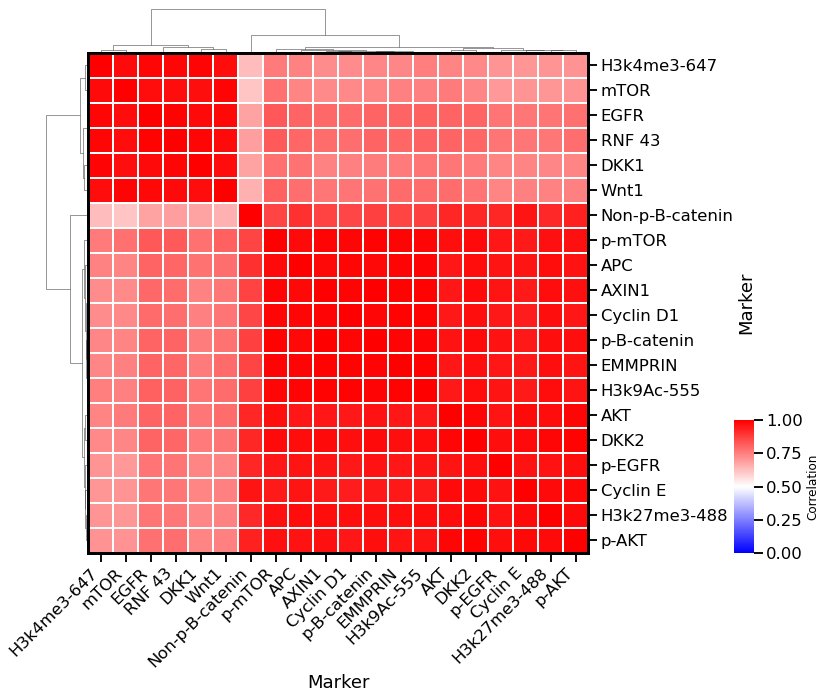

In [69]:
sns.set_context("talk")

create_HM(df_cell.corr(), 'bwr', 'Correlation', vmin=0, vmax=1)


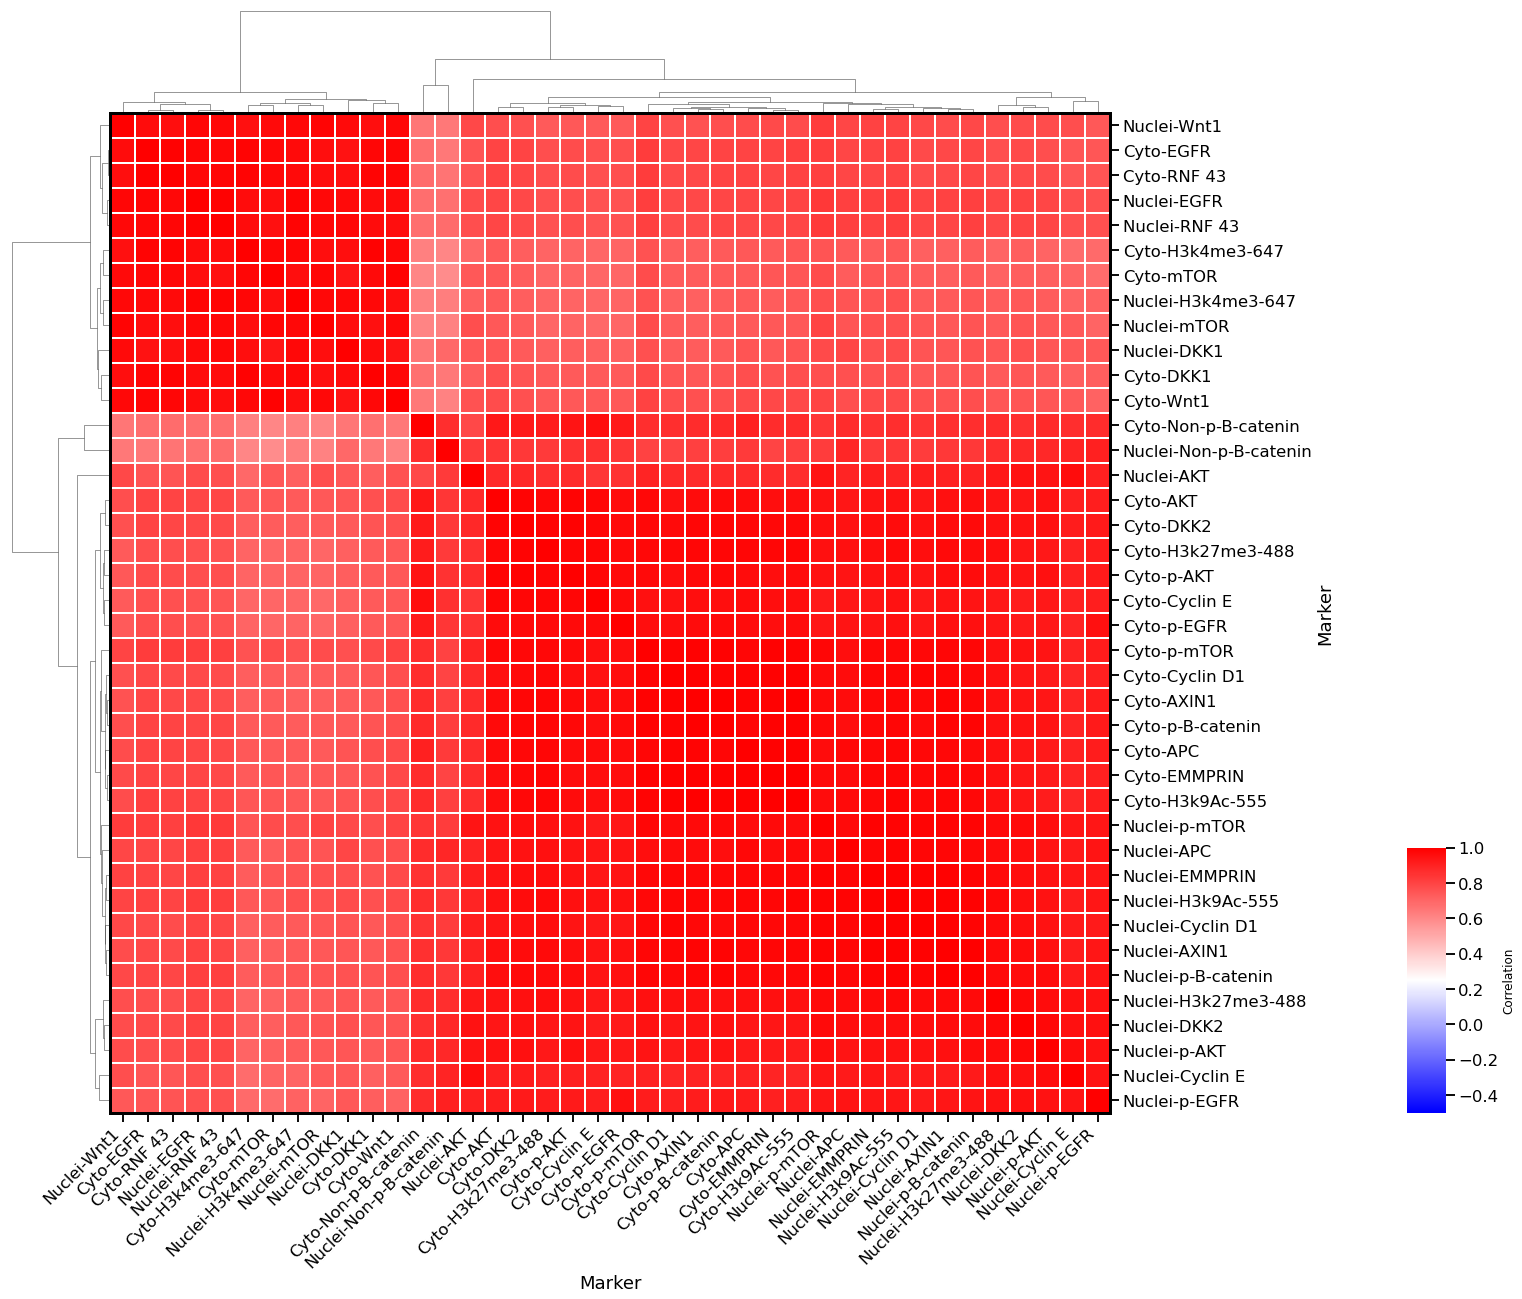

In [71]:
create_HM(df_per_cell_scaled.corr(), 'bwr', 'Correlation', vmin=-0.5, vmax=1)
